# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from dython import nominal

E:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import time series data: Airline data

In [2]:
train = pd.read_excel('Data_Train.xlsx', header = None, skiprows = 1)
train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
def import_col(data):
    if len(data.columns) == 11:
        data.columns = ['Airline','Date_of_Journey','Source','Destination','Route','Dep_Time',
                   'Arrival_Time','Duration','Total_Stops','Additional_Info','Price']
        
    else:
        data.columns = ['Airline','Date_of_Journey','Source','Destination','Route','Dep_Time',
                   'Arrival_Time','Duration','Total_Stops','Additional_Info']
        
    data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
    return data

In [4]:
train = import_col(train)
train = train.iloc[0:10682]
print(train.shape)
train.head()

(10682, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data Cleaning

In [5]:
print(round(100*(train.isnull().sum()/len(train)),2))


Airline            0.00
Date_of_Journey    0.00
Source             0.00
Destination        0.00
Route              0.01
Dep_Time           0.00
Arrival_Time       0.00
Duration           0.00
Total_Stops        0.01
Additional_Info    0.00
Price              0.00
dtype: float64


In [6]:
train.dropna(inplace = True, axis = 0)
print(round(100*(train.isnull().sum()/len(train)),2))

Airline            0.0
Date_of_Journey    0.0
Source             0.0
Destination        0.0
Route              0.0
Dep_Time           0.0
Arrival_Time       0.0
Duration           0.0
Total_Stops        0.0
Additional_Info    0.0
Price              0.0
dtype: float64


In [7]:
train['Destination'] = train['Destination'].apply(lambda x: 'Delhi' if x in ('Delhi','New Delhi') else x)
train['Destination'].unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [8]:
def route_new(data):
    temp = pd.DataFrame()
    temp['Busy'] = data['Source'].astype(str) + '_' + data['Destination'].astype(str)
    fig = plt.figure(figsize = (10,5))
    sns.countplot(temp['Busy'])
    plt.show()
    temp['Busy'] = temp['Busy'].apply(lambda x: 1if x in ('Bangalore_Delhi','Kolkata_Bangalore','Delhi_Cochin') 
                else 0)
    data = pd.concat([data,temp], axis = 1)
    data.drop(['Source','Destination','Route'], axis = 1, inplace = True)
    return data

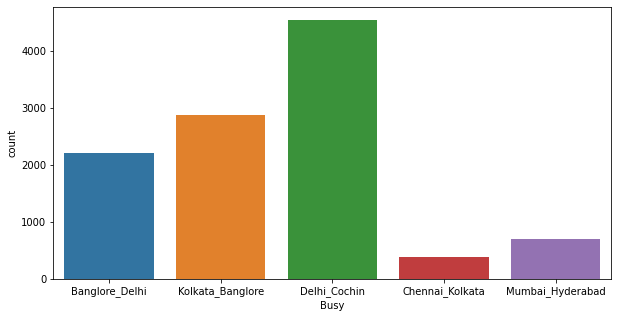

,Airline,Date_of_Journey,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Busy
0,IndiGo,2019-03-24,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,0
1,Air India,2019-05-01,05:50,13:15,7h 25m,2 stops,No info,7662,0
2,Jet Airways,2019-06-09,09:25,04:25 10 Jun,19h,2 stops,No info,13882,1
3,IndiGo,2019-05-12,18:05,23:30,5h 25m,1 stop,No info,6218,0
4,IndiGo,2019-03-01,16:50,21:35,4h 45m,1 stop,No info,13302,0


In [9]:
train = route_new(train)
train.head()

In [10]:
def duration(data):
    temp = pd.DataFrame()
    data[['Hour','Minute']] = data['Duration'].str.split(' ', expand=True)
    data['Hour'] = data['Hour'].str.replace('[a-zA-Z]', '')
    data['Minute'] = data['Minute'].str.replace('[a-zA-Z]','')
    data['Minute'] = data['Minute'].fillna(0)
    data['Duration_M'] = data['Hour'].astype(int) * 60 + data['Minute'].astype(int)
    data.drop(['Hour','Minute','Duration'], axis = 1, inplace = True)
    return data


In [11]:
train = duration(train)


In [12]:
train.head()

,Airline,Date_of_Journey,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Busy,Duration_M
0,IndiGo,2019-03-24,22:20,01:10 22 Mar,non-stop,No info,3897,0,170
1,Air India,2019-05-01,05:50,13:15,2 stops,No info,7662,0,445
2,Jet Airways,2019-06-09,09:25,04:25 10 Jun,2 stops,No info,13882,1,1140
3,IndiGo,2019-05-12,18:05,23:30,1 stop,No info,6218,0,325
4,IndiGo,2019-03-01,16:50,21:35,1 stop,No info,13302,0,285


In [13]:
"""
def departure(data):
    temp = pd.DataFrame()
    temp[['Dep_H','Dep_M']] = data['Dep_Time'].str.split(":", expand = True)
    data = pd.concat([data,temp], axis = 1)
    #data.drop('Dep_Time', axis = 1, inplace = True)
    temp = pd.DataFrame()
    temp['Time'] = data.apply(lambda x: 'MidNight' if (int(x['Dep_H']) in range(0,5) and int(x['Dep_M']) in range(0,55))
                              else 'Evening', axis = 1)
    data = pd.concat([data,temp], axis = 1)
    return data
    
"""

'\ndef departure(data):\n    temp = pd.DataFrame()\n    temp[[\'Dep_H\',\'Dep_M\']] = data[\'Dep_Time\'].str.split(":", expand = True)\n    data = pd.concat([data,temp], axis = 1)\n    #data.drop(\'Dep_Time\', axis = 1, inplace = True)\n    temp = pd.DataFrame()\n    temp[\'Time\'] = data.apply(lambda x: \'MidNight\' if (int(x[\'Dep_H\']) in range(0,5) and int(x[\'Dep_M\']) in range(0,55))\n                              else \'Evening\', axis = 1)\n    data = pd.concat([data,temp], axis = 1)\n    return data\n    \n'

In [14]:
def arrival(data):
    data.drop(['Arrival_Time'], axis = 1, inplace = True)
    return data

In [15]:
train = arrival(train)
train.head()

,Airline,Date_of_Journey,Dep_Time,Total_Stops,Additional_Info,Price,Busy,Duration_M
0,IndiGo,2019-03-24,22:20,non-stop,No info,3897,0,170
1,Air India,2019-05-01,05:50,2 stops,No info,7662,0,445
2,Jet Airways,2019-06-09,09:25,2 stops,No info,13882,1,1140
3,IndiGo,2019-05-12,18:05,1 stop,No info,6218,0,325
4,IndiGo,2019-03-01,16:50,1 stop,No info,13302,0,285


In [16]:
def departure(data):
    temp = pd.DataFrame()
    temp[['Dep_H','Dep_M']] = data['Dep_Time'].str.split(":", expand = True)
    data = pd.concat([data,temp], axis = 1)
    temp = pd.DataFrame()
    
    # Midnight = 1, Morning = 2, Noon = 3, Evening = 4
    temp['Time'] = data.apply(lambda x: 1 if (int(x['Dep_H']) in range(0,6) and int(x['Dep_M']) in range(0,60))
                              else (2 if (int(x['Dep_H']) in range(6,12) and int(x['Dep_M']) in range(0,60))
                              else (3 if (int(x['Dep_H']) in range(12,17) and int(x['Dep_M']) in range(0,60))
                              else 4)), axis = 1)
    data = pd.concat([data,temp], axis = 1)
    data.drop(['Dep_Time','Dep_H','Dep_M'], axis = 1, inplace = True)
    return data

In [17]:
temp = departure(train)
temp.head(20)

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time
0,IndiGo,2019-03-24,non-stop,No info,3897,0,170,4
1,Air India,2019-05-01,2 stops,No info,7662,0,445,1
2,Jet Airways,2019-06-09,2 stops,No info,13882,1,1140,2
3,IndiGo,2019-05-12,1 stop,No info,6218,0,325,4
4,IndiGo,2019-03-01,1 stop,No info,13302,0,285,3
5,SpiceJet,2019-06-24,non-stop,No info,3873,0,145,2
6,Jet Airways,2019-03-12,1 stop,In-flight meal not included,11087,0,930,4
7,Jet Airways,2019-03-01,1 stop,No info,22270,0,1265,2
8,Jet Airways,2019-03-12,1 stop,In-flight meal not included,11087,0,1530,2
9,Multiple carriers,2019-05-27,1 stop,No info,8625,1,470,2


In [18]:
train = departure(train)
train.head()

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time
0,IndiGo,2019-03-24,non-stop,No info,3897,0,170,4
1,Air India,2019-05-01,2 stops,No info,7662,0,445,1
2,Jet Airways,2019-06-09,2 stops,No info,13882,1,1140,2
3,IndiGo,2019-05-12,1 stop,No info,6218,0,325,4
4,IndiGo,2019-03-01,1 stop,No info,13302,0,285,3


In [19]:
train['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [20]:
train['Additional_Info'].value_counts(normalize = True)

No info                         0.781107
In-flight meal not included     0.185563
No check-in baggage included    0.029960
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
2 Long layover                  0.000094
1 Short layover                 0.000094
Red-eye flight                  0.000094
Name: Additional_Info, dtype: float64

In [21]:
def stop(data):
    data['Total_Stops'] = data['Total_Stops'].apply(lambda x: 0 if x in ('non-stop') else (1 if x in ('1 stop') 
                            else (2 if x in ('2 stops') else (3 if x in ('3 stops') else (4)))))

    return data

In [22]:
train.head()

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time
0,IndiGo,2019-03-24,non-stop,No info,3897,0,170,4
1,Air India,2019-05-01,2 stops,No info,7662,0,445,1
2,Jet Airways,2019-06-09,2 stops,No info,13882,1,1140,2
3,IndiGo,2019-05-12,1 stop,No info,6218,0,325,4
4,IndiGo,2019-03-01,1 stop,No info,13302,0,285,3


In [23]:
train['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [24]:
train = stop(train)

train.head()

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time
0,IndiGo,2019-03-24,0,No info,3897,0,170,4
1,Air India,2019-05-01,2,No info,7662,0,445,1
2,Jet Airways,2019-06-09,2,No info,13882,1,1140,2
3,IndiGo,2019-05-12,1,No info,6218,0,325,4
4,IndiGo,2019-03-01,1,No info,13302,0,285,3


In [25]:
train['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [26]:
def airline(data):
    data['Airline'] = data['Airline'].map({'IndiGo': 1, 'Air India': 2, 'Jet Airways' : 3, 'SpiceJet' : 4,
                           'Multiple carriers' : 5, 'GoAir' : 6, 'Vistara' : 7, 'Air Asia' : 8,
                           'Vistara Premium economy' : 9, 'Jet Airways Business' : 10,
                           'Multiple carriers Premium economy' : 11, 'Trujet' : 12})
    return data

In [27]:
train = airline(train)
train.head()

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time
0,1,2019-03-24,0,No info,3897,0,170,4
1,2,2019-05-01,2,No info,7662,0,445,1
2,3,2019-06-09,2,No info,13882,1,1140,2
3,1,2019-05-12,1,No info,6218,0,325,4
4,1,2019-03-01,1,No info,13302,0,285,3


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10681 entries, 0 to 10681
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10681 non-null  int64         
 1   Date_of_Journey  10681 non-null  datetime64[ns]
 2   Total_Stops      10681 non-null  int64         
 3   Additional_Info  10681 non-null  object        
 4   Price            10681 non-null  int64         
 5   Busy             10681 non-null  int64         
 6   Duration_M       10681 non-null  int32         
 7   Time             10681 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5), object(1)
memory usage: 709.3+ KB


In [29]:
import calendar
from datetime import datetime
train['WeekDay'] = train['Date_of_Journey'].dt.dayofweek
train.head()

,Airline,Date_of_Journey,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time,WeekDay
0,1,2019-03-24,0,No info,3897,0,170,4,6
1,2,2019-05-01,2,No info,7662,0,445,1,2
2,3,2019-06-09,2,No info,13882,1,1140,2,6
3,1,2019-05-12,1,No info,6218,0,325,4,6
4,1,2019-03-01,1,No info,13302,0,285,3,4


In [30]:
def date(data):
    data['Year'] = pd.to_datetime(data.Date_of_Journey, format='%d/%m/%Y').dt.year
    data['Year'].unique()
    data['Day'] = pd.to_datetime(data.Date_of_Journey, format='%d/%m/%Y').dt.day
    data['Month'] = pd.to_datetime(data.Date_of_Journey, format='%d/%m/%Y').dt.month
    data.drop(['Date_of_Journey','Year'], axis = 1, inplace = True)
    return data


In [31]:
train = date(train)
train.head()

,Airline,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time,WeekDay,Day,Month
0,1,0,No info,3897,0,170,4,6,24,3
1,2,2,No info,7662,0,445,1,2,1,5
2,3,2,No info,13882,1,1140,2,6,9,6
3,1,1,No info,6218,0,325,4,6,12,5
4,1,1,No info,13302,0,285,3,4,1,3


In [32]:
def info(data):
   # 0 - no Info
    data['Additional_Info'] = data['Additional_Info'].map({'No info': 1,'In-flight meal not included' : 2,
                              'No check-in baggage included' : 3,'1 Long layover': 4,'Change airports':5,
                               'Business class': 6,'Red-eye flight' : 7, '1 Short layover' :8,
                                '2 Long layover': 9})
    return data
                                                        
 
   

In [33]:

train = info(train)
train.head()

,Airline,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time,WeekDay,Day,Month
0,1,0,1.0,3897,0,170,4,6,24,3
1,2,2,1.0,7662,0,445,1,2,1,5
2,3,2,1.0,13882,1,1140,2,6,9,6
3,1,1,1.0,6218,0,325,4,6,12,5
4,1,1,1.0,13302,0,285,3,4,1,3


In [34]:
train['Additional_Info'].fillna(0, inplace = True, axis = 0)

In [35]:
train.head()

,Airline,Total_Stops,Additional_Info,Price,Busy,Duration_M,Time,WeekDay,Day,Month
0,1,0,1.0,3897,0,170,4,6,24,3
1,2,2,1.0,7662,0,445,1,2,1,5
2,3,2,1.0,13882,1,1140,2,6,9,6
3,1,1,1.0,6218,0,325,4,6,12,5
4,1,1,1.0,13302,0,285,3,4,1,3


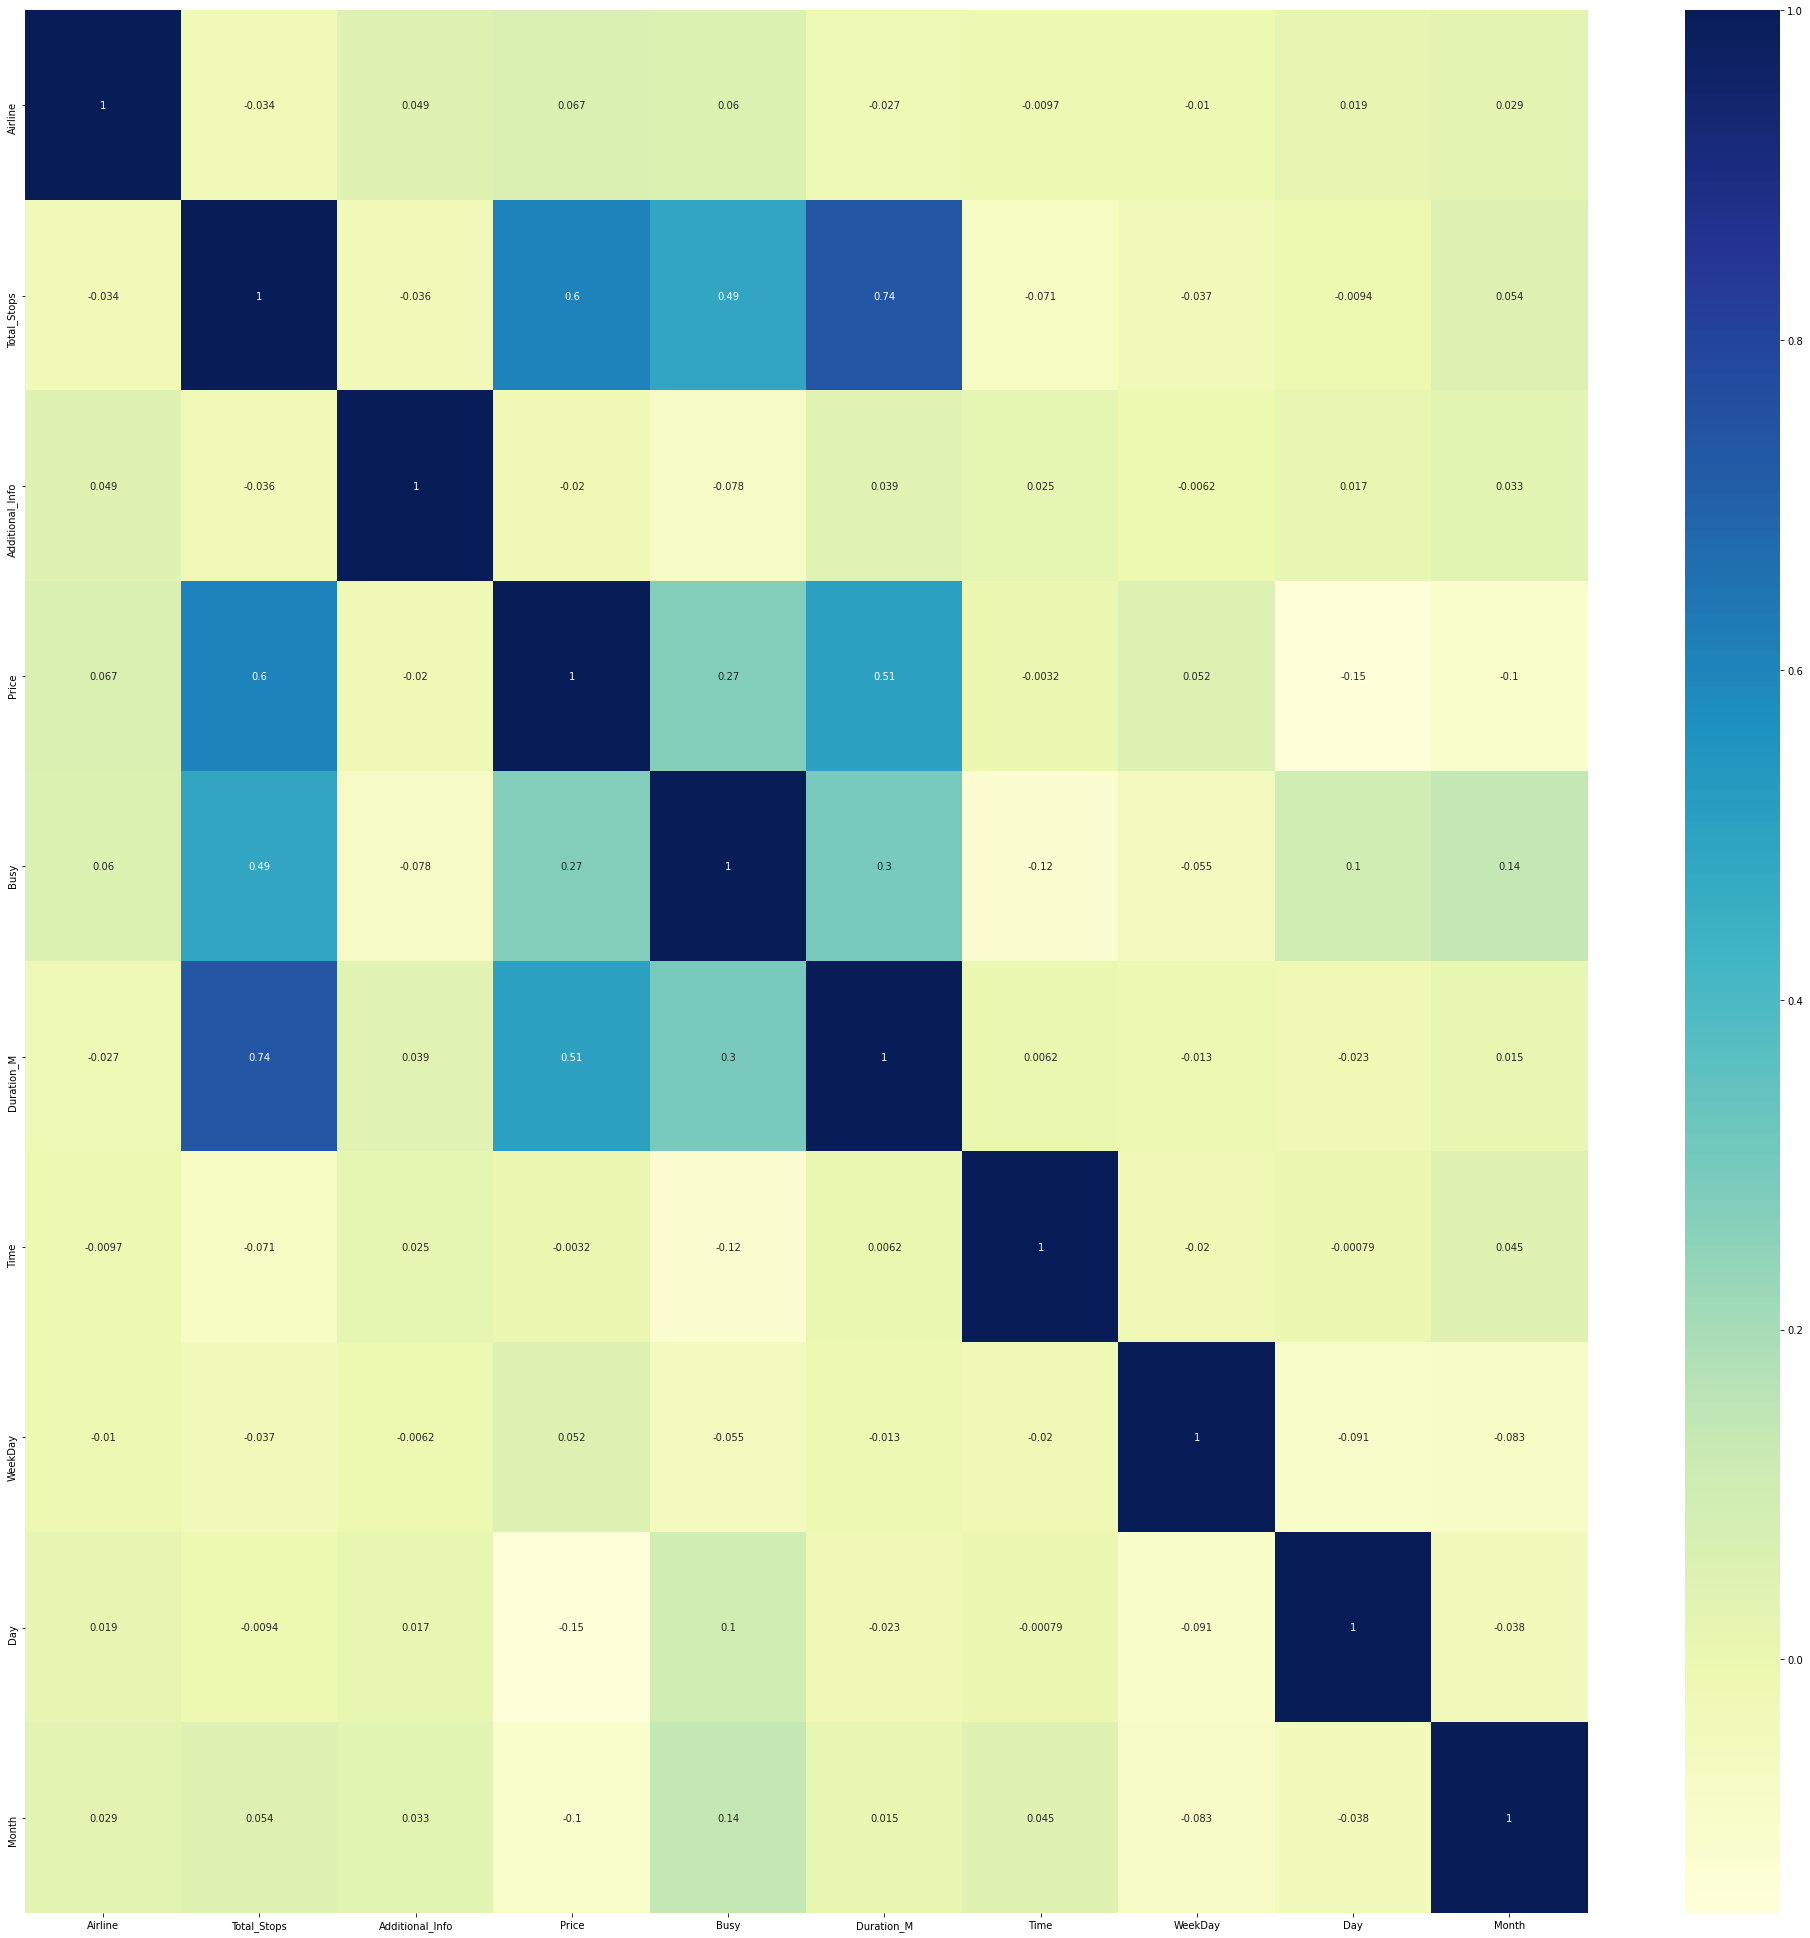

In [36]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize=(35,35))           
sns.heatmap(train.corr(),annot = True, cmap = 'YlGnBu')
plt.show()


In [37]:
#data.drop(['Source_Delhi','Destination_Hyderabad_Kolkata','Destination_Cochin'], axis = 1, inplace = True) #toal stops
#test_data.drop(['Source_Delhi','Destination_Hyderabad_Kolkata','Destination_Cochin'], axis = 1, inplace = True)


train.drop(['Duration_M'], axis = 1, inplace = True)

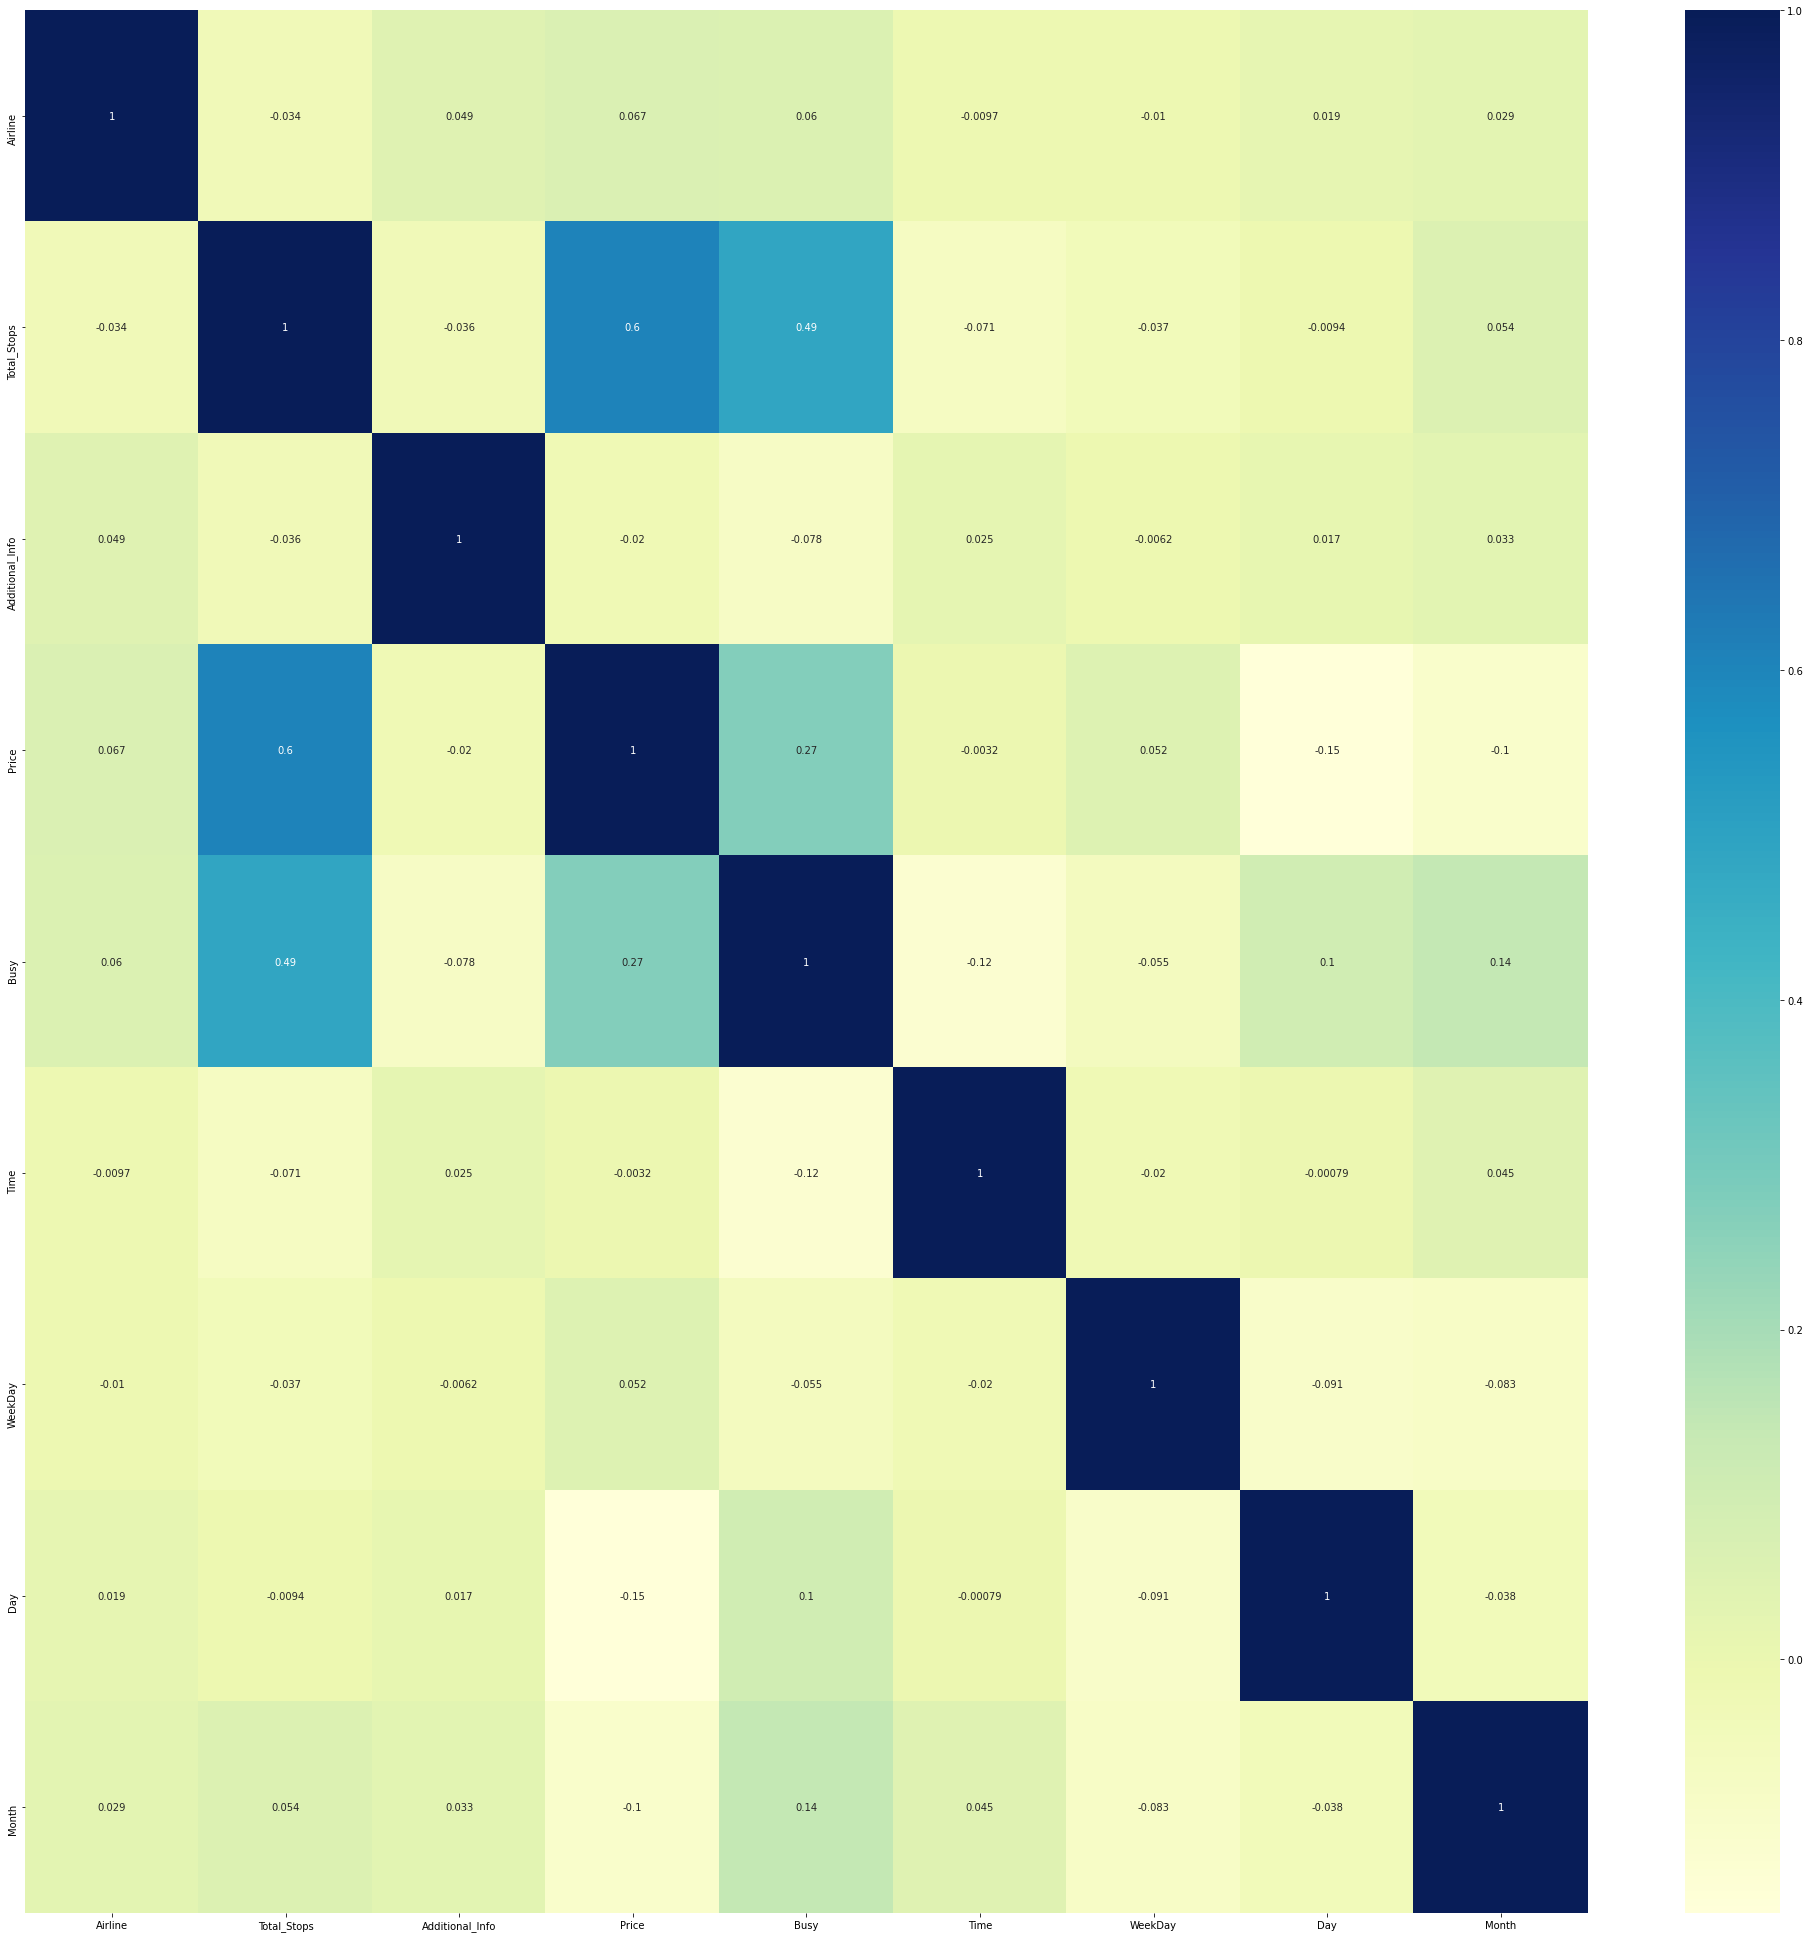

In [38]:

plt.figure(figsize=(35,35))           
sns.heatmap(train.corr(),annot = True, cmap = 'YlGnBu')
plt.show()

In [39]:
print(round(100*(train.isnull().sum()/len(train)),2))

Airline            0.0
Total_Stops        0.0
Additional_Info    0.0
Price              0.0
Busy               0.0
Time               0.0
WeekDay            0.0
Day                0.0
Month              0.0
dtype: float64


In [40]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
train,test = train_test_split(train, train_size = 0.7,random_state = 100)

print(train.shape)
print(test.shape)



(7476, 9)
(3205, 9)


In [41]:
#Calling scalar object : Using MinMax Scaling for scaling


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
var = train.columns
train[var] = scaler.fit_transform(train[var])

print(train.shape)
train.head()


(7476, 9)


,Airline,Total_Stops,Additional_Info,Price,Busy,Time,WeekDay,Day,Month
10227,0.090909,0.50,0.125,0.174145,0.0,0.666667,0.166667,0.769231,0.666667
3770,0.181818,0.25,0.125,0.213539,1.0,1.000000,0.500000,0.192308,1.000000
1535,0.272727,0.00,0.375,0.034845,0.0,1.000000,1.000000,0.884615,0.000000
3294,0.181818,0.50,0.125,0.323334,0.0,0.666667,0.333333,0.192308,0.000000
6679,0.090909,0.25,0.125,0.109003,1.0,0.333333,0.333333,0.538462,0.666667


In [42]:

var = test.columns
test[var] = scaler.transform(test[var])

print(test.shape)
test.head()


(3205, 9)


,Airline,Total_Stops,Additional_Info,Price,Busy,Time,WeekDay,Day,Month
8475,0.545455,0.25,0.125,0.110322,0.0,0.333333,0.000000,0.000000,0.333333
6421,0.181818,0.25,0.250,0.140156,1.0,0.333333,0.000000,0.884615,1.000000
3102,0.181818,0.50,0.125,0.182304,1.0,1.000000,0.000000,0.884615,1.000000
5795,0.181818,0.00,0.125,0.128651,1.0,0.333333,0.833333,0.538462,1.000000
8294,0.000000,0.25,0.125,0.064696,1.0,0.333333,0.500000,1.000000,1.000000


In [43]:
# Describing Scaled variables

test[var].describe()

,Airline,Total_Stops,Additional_Info,Price,Busy,Time,WeekDay,Day,Month
count,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000,3205.000000
mean,0.200028,0.204212,0.156903,0.118845,0.427457,0.565783,0.484971,0.480943,0.575975
std,0.167719,0.168846,0.068751,0.075830,0.494787,0.341475,0.336735,0.326885,0.388342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090909,0.000000,0.125000,0.057065,0.000000,0.333333,0.166667,0.192308,0.333333
50%,0.181818,0.250000,0.125000,0.104503,0.000000,0.333333,0.500000,0.423077,0.666667
75%,0.272727,0.250000,0.125000,0.172793,1.000000,1.000000,0.833333,0.769231,1.000000
max,0.909091,0.750000,1.125000,1.281615,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X and Y sets for the model building

In [44]:
"""from sklearn.model_selection import train_test_split
train,test = train_test_split(train, train_size = 0.8,random_state = 100)
"""

print(train.shape)
print(test.shape)


(7476, 9)
(3205, 9)


In [45]:
X_train = train
y_train = train.pop('Price')

X_test = test
y_test = test.pop('Price')

In [46]:
X_train.head()

,Airline,Total_Stops,Additional_Info,Busy,Time,WeekDay,Day,Month
10227,0.090909,0.50,0.125,0.0,0.666667,0.166667,0.769231,0.666667
3770,0.181818,0.25,0.125,1.0,1.000000,0.500000,0.192308,1.000000
1535,0.272727,0.00,0.375,0.0,1.000000,1.000000,0.884615,0.000000
3294,0.181818,0.50,0.125,0.0,0.666667,0.333333,0.192308,0.000000
6679,0.090909,0.25,0.125,1.0,0.333333,0.333333,0.538462,0.666667


In [47]:
y_train.head()

10227    0.174145
3770     0.213539
1535     0.034845
3294     0.323334
6679     0.109003
Name: Price, dtype: float64

In [48]:
X_test.head()

,Airline,Total_Stops,Additional_Info,Busy,Time,WeekDay,Day,Month
8475,0.545455,0.25,0.125,0.0,0.333333,0.000000,0.000000,0.333333
6421,0.181818,0.25,0.250,1.0,0.333333,0.000000,0.884615,1.000000
3102,0.181818,0.50,0.125,1.0,1.000000,0.000000,0.884615,1.000000
5795,0.181818,0.00,0.125,1.0,0.333333,0.833333,0.538462,1.000000
8294,0.000000,0.25,0.125,1.0,0.333333,0.500000,1.000000,1.000000


In [49]:
y_test.head()

8475    0.110322
6421    0.140156
3102    0.182304
5795    0.128651
8294    0.064696
Name: Price, dtype: float64

In [50]:
print(round(100*(train.isnull().sum()/len(train)),2))
print(round(100*(test.isnull().sum()/len(test)),2))

Airline            0.0
Total_Stops        0.0
Additional_Info    0.0
Busy               0.0
Time               0.0
WeekDay            0.0
Day                0.0
Month              0.0
dtype: float64
Airline            0.0
Total_Stops        0.0
Additional_Info    0.0
Busy               0.0
Time               0.0
WeekDay            0.0
Day                0.0
Month              0.0
dtype: float64


## Step 5: Model Building

In [56]:
# Running RFE with the output number of the variable equal to 15
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
lm = LinearRegression()

rfe = RFE(lm,5)
rfe = rfe.fit(X_train,y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False False False  True  True]
[1 1 1 4 2 3 1 1]


In [57]:
list(zip(X_train,rfe.support_,rfe.ranking_))

[('Airline', True, 1),
 ('Total_Stops', True, 1),
 ('Additional_Info', True, 1),
 ('Busy', False, 4),
 ('Time', False, 2),
 ('WeekDay', False, 3),
 ('Day', True, 1),
 ('Month', True, 1)]

In [58]:
col = X_train.columns[rfe.support_]
col

Index(['Airline', 'Total_Stops', 'Additional_Info', 'Day', 'Month'], dtype='object')

In [59]:
X_train.columns[~rfe.support_]

Index(['Busy', 'Time', 'WeekDay'], dtype='object')

## Step 6. Building model using statsmodel, for the detailed statistics

In [60]:
##RFE: Creating X dataframe with RFE selected variables
import statsmodels.api as sm
X = X_train

# Adding a constant variable 
X_train_lm = sm.add_constant(X)

# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit() 

# summary of linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     705.0
Date:                Fri, 08 Jan 2021   Prob (F-statistic):               0.00
Time:                        09:59:14   Log-Likelihood:                 10753.
No. Observations:                7476   AIC:                        -2.149e+04
Df Residuals:                    7467   BIC:                        -2.143e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0805      0.003     

In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
dt = DecisionTreeRegressor(random_state=42)

In [107]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["mse"]
}

In [108]:
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator=dt, 
                           param_distributions =params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "r2")

In [109]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 461 ms


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished


RandomizedSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse'],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, 15, 16,
                                                      17, 18, 19, 20, 21, 22,
                                                      23, 24, 25, 26, 27, 28,
                                                      29],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100]},
                   scoring='r2', verbose=1)

In [110]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015690,0.001872,0.004368,0.002646,100,15,mse,"{'min_samples_leaf': 100, 'max_depth': 15, 'cr...",0.655805,0.691331,0.657016,0.735511,0.684916,0.032507,7
1,0.020881,0.001732,0.004263,0.001089,10,10,mse,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.760679,0.783454,0.731873,0.807912,0.770979,0.028085,3
2,0.024676,0.001248,0.006794,0.001316,5,27,mse,"{'min_samples_leaf': 5, 'max_depth': 27, 'crit...",0.764194,0.808493,0.733377,0.815588,0.780413,0.033546,1
3,0.016505,0.002471,0.006287,0.002685,100,28,mse,"{'min_samples_leaf': 100, 'max_depth': 28, 'cr...",0.655805,0.691331,0.657016,0.735511,0.684916,0.032507,7
4,0.020465,0.003671,0.002941,0.001169,50,20,mse,"{'min_samples_leaf': 50, 'max_depth': 20, 'cri...",0.693267,0.710565,0.698025,0.759182,0.715260,0.026134,5


In [111]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,0.024676,0.001248,0.006794,0.001316,5,27,mse,"{'min_samples_leaf': 5, 'max_depth': 27, 'crit...",0.764194,0.808493,0.733377,0.815588,0.780413,0.033546,1
5,0.032307,0.002003,0.005594,0.000609,5,20,mse,"{'min_samples_leaf': 5, 'max_depth': 20, 'crit...",0.764194,0.808493,0.733377,0.815588,0.780413,0.033546,1
1,0.020881,0.001732,0.004263,0.001089,10,10,mse,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.760679,0.783454,0.731873,0.807912,0.770979,0.028085,3
6,0.020723,0.002606,0.004865,0.002533,20,27,mse,"{'min_samples_leaf': 20, 'max_depth': 27, 'cri...",0.731638,0.747157,0.722428,0.796115,0.749334,0.028418,4
4,0.020465,0.003671,0.002941,0.001169,50,20,mse,"{'min_samples_leaf': 50, 'max_depth': 20, 'cri...",0.693267,0.710565,0.698025,0.759182,0.715260,0.026134,5


In [112]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=27, min_samples_leaf=5, random_state=42)

In [113]:
dt_best = grid_search.best_estimator_

In [114]:
def evaluate(dt):
    print("Train Accuracy :", r2_score(y_train, dt.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", r2_score(y_test, dt.predict(X_test)))
    print(dt.feature_importances_)

In [115]:
evaluate(dt_best)

Train Accuracy : 0.8511167163307296
--------------------------------------------------
Test Accuracy : 0.8161459552828212
[0.24026015 0.47943408 0.06054093 0.01268097 0.01415795 0.0113726
 0.11225403 0.0692993 ]


Feature: 0, Score: 0.24431
Feature: 1, Score: 0.48823
Feature: 2, Score: 0.06170
Feature: 3, Score: 0.01179
Feature: 4, Score: 0.00859
Feature: 5, Score: 0.00792
Feature: 6, Score: 0.10780
Feature: 7, Score: 0.06967


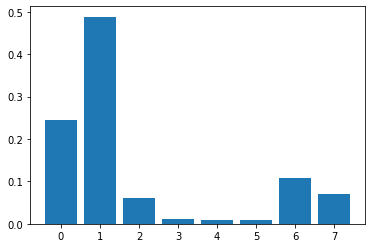

In [104]:

importance = dt_best.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [105]:
for name, importance in zip(X_train.columns, dt_best.feature_importances_):
    print(name, importance)

Airline 0.24430760242309638
Total_Stops 0.4882321229637872
Additional_Info 0.061695073282729995
Busy 0.011785021176196937
Time 0.0085933522020672
WeekDay 0.00791622606785268
Day 0.10779628861240456
Month 0.06967431327186506


In [61]:
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

k_range = list(range(1,30, 2))
param_distributions = dict(n_neighbors = k_range)
knn_regressor = RandomizedSearchCV(KNeighborsRegressor(), param_distributions, cv =10, scoring = 'neg_mean_squared_error')
knn_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(),
                   param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15, 17, 19, 21, 23, 25,
                                                        27, 29]},
                   scoring='neg_mean_squared_error')

In [63]:
print(knn_regressor.best_score_)
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

-0.0019951965082865104
KNeighborsRegressor(n_neighbors=3)


{'n_neighbors': 3}

In [64]:
k = KNeighborsRegressor(n_neighbors = 3)

In [65]:
k.fit(X_train, y_train)

y_train_pred = k.predict(X_train) 
y_test_pred = k.predict(X_test)  

In [66]:
print(y_train_pred)
print(y_test_pred)

[0.20472627 0.21353926 0.02551592 ... 0.06628975 0.05230654 0.17372146]
[0.1019593  0.14015626 0.18755632 ... 0.22206105 0.05613613 0.13022791]


In [67]:


print("KNN Regressor Model Train :")
print("RMSE: ", sqrt(mse(y_train.values, y_train_pred)))
print("MAPE: ", round(mean_absolute_percentage_error(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

#83 without scaling
# 78 with scaling, 78 with sknew treatment - 93,83 for rf best - 81,75 with dummies,91-84 with dummies rf
# With full data - 0.26,0.2 instead of 

KNN Regressor Model Train :
RMSE:  0.03378826529714529
MAPE:  inf
R-squared:  0.8027573255311183


In [68]:
print("KNN Regressor Model Train :")
print("RMSE: ",sqrt(mse(y_test, y_test_pred)))
print("MAPE ", round(mean_absolute_percentage_error(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))



KNN Regressor Model Train :
RMSE:  0.04148169272204888
MAPE  inf
R-squared:  0.7006621092502774


In [69]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
regressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50, random_state=0)

In [70]:
Y_Pred = regressor.predict(X_train)
Y_Pred_test = regressor.predict(X_test)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(Y_Pred, y_train)
r2_score(Y_Pred, y_train)

0.8661184621336111

In [72]:
mean_squared_error(Y_Pred_test, y_test)
r2_score(Y_Pred_test, y_test)

0.8077441184009054

In [73]:

params = { 
    'n_estimators': [200, 100, 300,400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,10,12,16,20]
}

In [74]:
# Stratified K Fold and RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 50,
             cv = 10,verbose=2, random_state=42, n_jobs = -1) #, scoring='mean_squared_error')

In [75]:
# Fitting the model on train data
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [8, 10, 12, 16, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 100, 300, 400]},
                   random_state=42, verbose=2)

In [76]:
# Scores of RandomizedSearchCV
scores = rf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.143730,0.063777,0.068887,0.007137,200,auto,8,"{'n_estimators': 200, 'max_features': 'auto', ...",0.709821,0.788870,...,0.861868,0.770722,0.819542,0.752583,0.775206,0.851607,0.814215,0.793091,0.043309,27
1,0.740313,0.027819,0.038526,0.006207,100,sqrt,8,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.706968,0.715210,...,0.787061,0.702662,0.754044,0.680820,0.706204,0.797667,0.759144,0.734576,0.036838,49
2,5.303860,0.127760,0.105971,0.020544,200,auto,16,"{'n_estimators': 200, 'max_features': 'auto', ...",0.735374,0.806979,...,0.880645,0.795830,0.819072,0.744691,0.784401,0.832432,0.819011,0.798580,0.041074,15
3,1.583924,0.053889,0.055106,0.006902,100,log2,16,"{'n_estimators': 100, 'max_features': 'log2', ...",0.761347,0.781795,...,0.877739,0.791270,0.816317,0.739916,0.768521,0.825204,0.808735,0.792999,0.038344,28
4,2.034915,0.105918,0.043872,0.006380,100,auto,10,"{'n_estimators': 100, 'max_features': 'auto', ...",0.746272,0.810264,...,0.880567,0.790552,0.830651,0.762578,0.805574,0.864517,0.831489,0.811426,0.039823,1


In [77]:
print(rf_random.best_score_)
print(rf_random.best_params_)
print(rf_random.best_index_)

0.8114261716519143
{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10}
4


In [92]:
# Passing the best parameteres based on Randomized Search CV

rf_tuned = RandomForestRegressor(bootstrap=True,
                               max_depth=10,
                               max_features='auto',
                               n_estimators= 100,
                               n_jobs=-1, 
                               random_state=5)

In [93]:
# Fitting the model on Train data and Predicting on Test Data
from sklearn.metrics import r2_score

rf_tuned.fit(X_train,y_train)

y_pred_train = rf_tuned.predict(X_train)
y_pred_test = rf_tuned.predict(X_test)

print('R2 Train:', r2_score(y_train, y_pred_train))
print('R2 Test :', r2_score(y_test, y_pred_test))
print(y_pred_test)


R2 Train: 0.8644413041627341
R2 Test : 0.8421631251505105
[0.11133881 0.14230497 0.19814003 ... 0.22540005 0.08831406 0.13649616]
